In [1]:
#from memory_profiler import profile
import fzMPI
from mpi4py import MPI

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np

import compute_charge_dist as fz

%matplotlib inline

Loading the library to compute the charge distribution of dust grains.


In [2]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [3]:
fzMPI.print_to_logfile("Initializing clock.")

# Input variables.
data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

yt : [INFO     ] 2018-11-13 17:36:27,766 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-11-13 17:36:27,772 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 17:36:27,773 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 17:36:27,774 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 17:36:27,774 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 17:36:27,794 Parameters: current_time              = 5.68049127342e+14
yt : [INFO     ] 2018-11-13 17:36:27,795 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-11-13 17:36:27,797 Parameters: domain_left_edge          = [ -1.97478400e+20  -4.93696000e+19  -4.93696000e+19]
yt : [INFO     ] 2018-11-13 17:36:27,798 Parameters: domain_righ

Initializing clock.


In [4]:
c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box_units = pf.box(le, re)

keys = ["nH", "dens", "temp", "ne", "xe", "cdto", "nC", "xHp", "xCp", "xH2", "cell_mass", "nH2", "cdh2"]

box = {"info":"dictionary without the units"}

for key in keys:
    box[key] = box_units[key].value

In [5]:
ncells = len(box["nH"])

num_cells     = np.int(1.0e4)

In [6]:
min_dens = np.min(box["dens"])
max_dens = np.max(box["dens"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temp"])
max_temp = np.max(box["temp"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

In [7]:
np.random.seed(1)
#np.random.seed(2)

ncells = len(box["nH"])
n1     = np.int(ncells * 0.01)
#n5 = int(1.0e3)
rand_index = np.random.randint(0, ncells, n1)

# In[24]:
temp1= np.array(box["temp"][rand_index])
dd1  = np.array(box["dens"][rand_index])
nH1  = np.array(box["nH"]  [rand_index])
nH21 = np.array(box["nH2"] [rand_index])
nC1  = np.array(box["nC"]  [rand_index])
ne1  = np.array(box["ne"]  [rand_index])
xe1  = np.array(box["xe"]  [rand_index])
xHp1 = np.array(box["xHp"] [rand_index])
xH21 = np.array(box["xH2"] [rand_index])
xCp1 = np.array(box["xCp"] [rand_index])
Av1  = np.array(box["cdto"][rand_index])
fH2shield1 = np.array(box["cdh2"][rand_index])


In [8]:
np.random.seed(1)
#np.random.seed(2)

ncells = len(box["nH"])
n50     = np.int(ncells * 0.5)
#n5 = int(1.0e3)
rand_index50 = np.random.randint(0, ncells, n50)

# In[24]:
temp50= np.array(box["temp"][rand_index50])
dd50  = np.array(box["dens"][rand_index50])
nH50  = np.array(box["nH"]  [rand_index50])
nH250 = np.array(box["nH2"] [rand_index50])
nC50  = np.array(box["nC"]  [rand_index50])
ne50  = np.array(box["ne"]  [rand_index50])
xe50  = np.array(box["xe"]  [rand_index50])
xHp50 = np.array(box["xHp"] [rand_index50])
xH250 = np.array(box["xH2"] [rand_index50])
xCp50 = np.array(box["xCp"] [rand_index50])
Av50  = np.array(box["cdto"][rand_index50])
fH2shield50 = np.array(box["cdh2"][rand_index50])


In [9]:
h2da, xx, yy = np.histogram2d(np.log10(box["nH"]), np.log10(box["temp"]), bins=50, normed=True)
h2db, xx, yy = np.histogram2d(np.log10(box["nH"]), box["cdto"], bins=50, range=([[np.log10(min_nh), np.log10(max_nh)],[min_ne, max_ne]]), normed=True)
h2dc, xx, yy = np.histogram2d(np.log10(box["nH"]), box["ne"],   bins=50, range=([[np.log10(min_nh), np.log10(max_nh)],[min_ne, max_ne]]), normed=True)

import pickle
outfile = open('/home/jcibanezm/codes/DustAnalysis/Charge/PaperFigures_DustCharge/new_xe.pkl', 'rb')
new_xe = pickle.load(outfile)
#pickle.dump(xe_new1000, outfile)
outfile.close()

In [10]:
new_xe = np.zeros_like(box["nH"])
new_ne = np.zeros_like(box["nH"])
Ntot = box["cdto"]*1.87e21

for i in range(len(new_xe)):
#for i in range(10):
    #print(i)
    zeta = fz.get_zeta(Ntot[i])
    new_ne[i], new_xe[i] = fz.compute_new_xe([box["nH"][i], box["nC"][i]], [box["xHp"][i], box["xCp"][i]], box["xH2"][i], zeta) 

/home/jcibanezm/codes/DustCharge/compute_charge_dist.py:2288: RuntimeWarning: invalid value encountered in double_scalars
  zeta  += K[kk]*np.power(np.log10(NH), kk)


In [11]:
xe1 = np.array(new_xe[rand_index])
xe50= np.array(new_xe[rand_index50])

In [12]:
box_mass50 = np.array(box["cell_mass"][rand_index50])
box_mass1  = np.array(box["cell_mass"][rand_index])

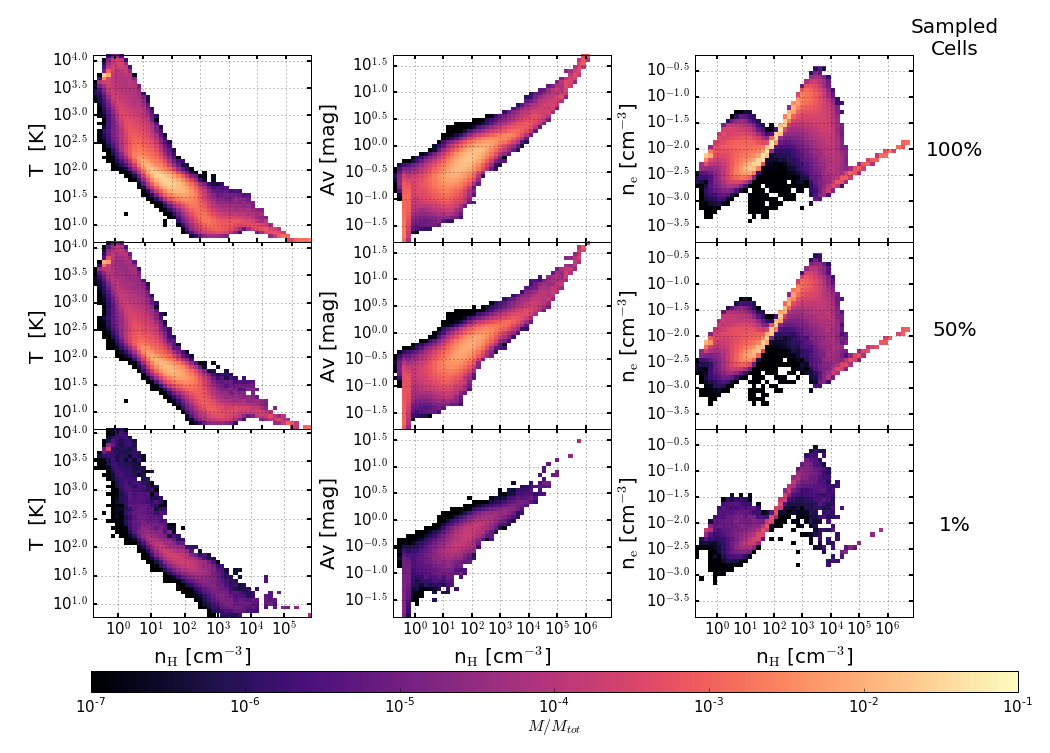

In [22]:
xsize = 14
ysize = 10

nfigs_x = 3
nfigs_y = 3

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.16
wpad = 0.073
w0   = 0.065

xs_panel = 0.650 / nfigs_x 
ys_panel = 0.78 / nfigs_y 

ax = fig.add_axes([0, 0, 1, 1])

# Formatting tick labels in log scale.
def format_func(value, tick_number):
    return "10$^{%.1f}$"%value

# Formatting tick labels in log scale.
def format_func2(value, tick_number):
    return "10$^{%i}$"%value

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.text(0.92, 0.94, "Sampled\nCells", fontsize=20, horizontalalignment='center')
ax.text(0.92, 0.8, "100%", fontsize=20, horizontalalignment='center')
ax.text(0.92, 0.55, "50%", fontsize=20, horizontalalignment='center')
ax.text(0.92, 0.28, "1%", fontsize=20, horizontalalignment='center')

plt.axis('off')

total_mass = np.sum(box["cell_mass"])


############################################################################################################
############################               100 %                   #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 2


ax = fig.add_axes([w0 + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

#H, xc, yc = np.histogram2d(np.log10(box["nH"]), np.log10(box["temp"]), weights=box["cell_mass"].in_units("Msun"), bins=50)
#H_norm = H / np.sum(box["cell_mass"].in_units("Msun").value)

cax = ax.hist2d(np.log10(box["nH"]), np.log10(box["temp"]), weights=box["cell_mass"]/total_mass, bins=50, norm=LogNorm(), cmap="magma", vmin=1.0e-7, vmax=0.1)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=18, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=18, direction="in")
ax.grid("on")


ax.set_ylabel("T  [K]", fontsize=20)
ax.set_xlabel("n$_{\\mathrm{H}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 2


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(box["nH"]), np.log10(box["cdto"]), bins=50, norm=LogNorm(),weights=box["cell_mass"]/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_Av), np.log10(50.0)]]), vmin=1.0e-7, vmax=0.1)
#ax.hist2d(np.log10(box["nH"]), G, bins=50, norm=LogNorm(), normed=True, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.min(G), np.max(G)]]))

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.set_ylabel("Av [mag]", fontsize=20)
#ax.set_ylabel("G", fontsize=20)
ax.set_xlabel("n$_{\\mathrm{H}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 2


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad+0.01, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(box["nH"]), np.log10(new_ne), bins=50, norm=LogNorm(), weights=box["cell_mass"]/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_ne), np.log10(max_ne)]]), vmin=1.0e-7, vmax=0.1)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.set_xlabel("n$_{\\mathrm{H}}$ [cm$^{-3}$]", fontsize=20)
ax.set_ylabel("n$_{\\mathrm{e}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.set_ylim(-3.8, -0.2)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


############################################################################################################
############################               50 %                   #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 1


ax = fig.add_axes([w0 + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

#H, xc, yc = np.histogram2d(np.log10(box["nH"]), np.log10(box["temp"]), weights=box["cell_mass"].in_units("Msun"), bins=50)
#H_norm = H / np.sum(box["cell_mass"].in_units("Msun").value)

cax = ax.hist2d(np.log10(nH50), np.log10(temp50), weights=box_mass50/total_mass, bins=50, norm=LogNorm(), cmap="magma", vmin=1.0e-7, vmax=0.1)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=18, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=18, direction="in")
ax.grid("on")


ax.set_ylabel("T  [K]", fontsize=20)
ax.set_xlabel("n$_{\\mathrm{H}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 1


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(nH50), np.log10(Av50), bins=50, norm=LogNorm(),weights=box_mass50/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_Av), np.log10(50.0)]]), vmin=1.0e-7, vmax=0.1)
#ax.hist2d(np.log10(box["nH"]), G, bins=50, norm=LogNorm(), normed=True, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.min(G), np.max(G)]]))

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.set_ylabel("Av [mag]", fontsize=20)
#ax.set_ylabel("G", fontsize=20)
ax.set_xlabel("n$_{\\mathrm{H}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 1


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad+0.01, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(nH50), np.log10(nH50*xe50), bins=50, norm=LogNorm(), weights=box_mass50/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_ne), np.log10(max_ne)]]), vmin=1.0e-7, vmax=0.1)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.set_xlabel("n$_{\\mathrm{H}}$ [cm$^{-3}$]", fontsize=20)
ax.set_ylabel("n$_{\\mathrm{e}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.set_ylim(-3.8, -0.2)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


############################################################################################################
############################               1 %                   #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0


ax = fig.add_axes([w0 + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

#H, xc, yc = np.histogram2d(np.log10(box["nH"]), np.log10(box["temp"]), weights=box["cell_mass"].in_units("Msun"), bins=50)
#H_norm = H / np.sum(box["cell_mass"].in_units("Msun").value)

cax = ax.hist2d(np.log10(nH1), np.log10(temp1), weights=box_mass1/total_mass, bins=50, norm=LogNorm(), cmap="magma", vmin=1.0e-7, vmax=0.1)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=18, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=18, direction="in")
ax.grid("on")


ax.set_ylabel("T  [K]", fontsize=20)
ax.set_xlabel("n$_{\\mathrm{H}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(nH1), np.log10(Av1), bins=50, norm=LogNorm(),weights=box_mass1/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_Av), np.log10(50.0)]]), vmin=1.0e-7, vmax=0.1)
#ax.hist2d(np.log10(box["nH"]), G, bins=50, norm=LogNorm(), normed=True, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.min(G), np.max(G)]]))

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.set_ylabel("Av [mag]", fontsize=20)
#ax.set_ylabel("G", fontsize=20)
ax.set_xlabel("n$_{\\mathrm{H}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 0


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad+0.01, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(nH1), np.log10(nH1*xe1), bins=50, norm=LogNorm(), weights=box_mass1/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_ne), np.log10(max_ne)]]), vmin=1.0e-7, vmax=0.1)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.set_xlabel("n$_{\\mathrm{H}}$ [cm$^{-3}$]", fontsize=20)
ax.set_ylabel("n$_{\\mathrm{e}}$ [cm$^{-3}$]", fontsize=20)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)

ax.set_ylim(-3.8, -0.2)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


# Add colorbar.

#cax[3] = cax[3]/np.sum(box["cell_mass"].in_units("Msun").value)

cbar_ax = fig.add_axes([wpad-0.01, 0.055, 0.92, 0.03])
cbar    = fig.colorbar(cax[3], cax=cbar_ax, orientation="horizontal")
#cbar    = fig.colorbar(cax, cax=cbar_ax, orientation="horizontal")

cbar.set_label("$M/M_{tot}$", fontsize=16, labelpad=1)
cbar.ax.tick_params(labelsize=15)

fig.show()

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Apendix/AppendixE_phasePlots.pdf", format="pdf")

